In [68]:
# !pip install eda_toolkit
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import kagglehub
import time
from datetime import datetime
from eda_toolkit import flex_corr_matrix
import seaborn as sns
from matplotlib.patches import Rectangle
import math
import warnings
from matplotlib import gridspec

Using Colab cache for faster access to the 'lung-cancer-prediction-dataset' dataset.
======== Preview of Data ======== 
Sample of the data:
   age  gender  education_years  income_level  smoker  smoking_years  \
0   60       1               20             2       1             16   
1   53       0               12             4       0              0   
2   62       1               15             3       1              9   
3   73       1               12             3       0              0   
4   52       1               13             1       0              0   

   cigarettes_per_day  pack_years  passive_smoking  air_pollution_index  ...  \
0                  15          12                0                   71  ...   
1                   0           0                1                   66  ...   
2                  29          13                1                   69  ...   
3                   0           0                0                   47  ...   
4                   0      

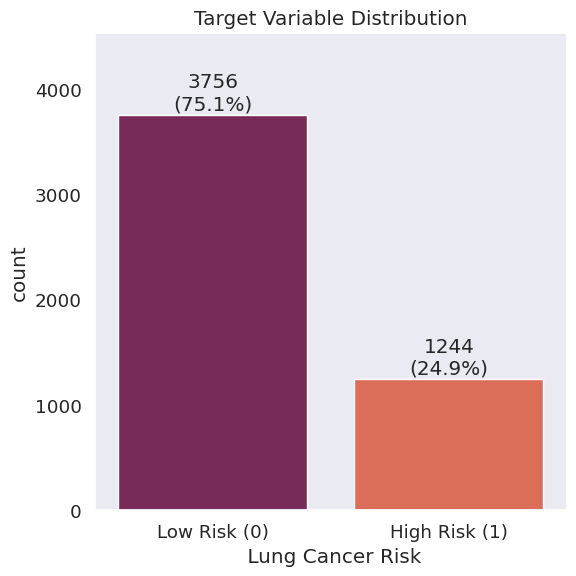

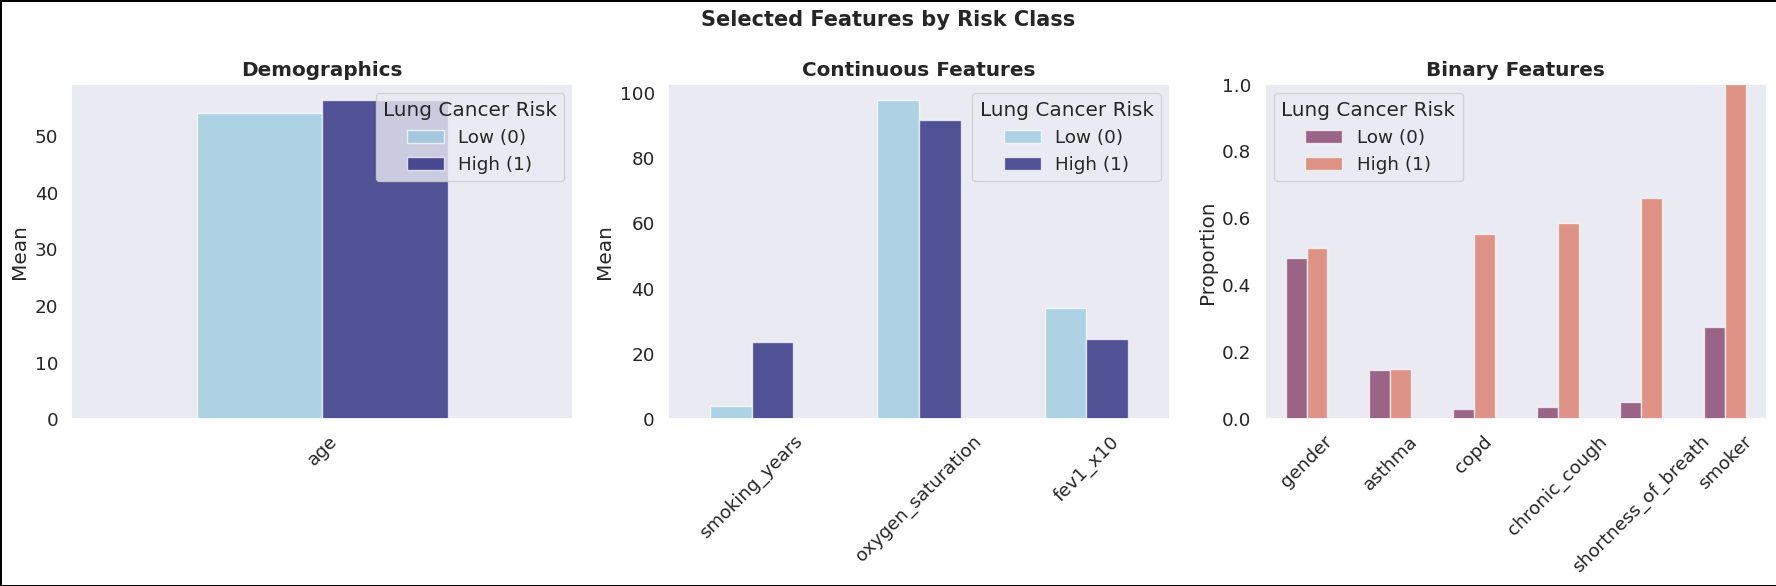

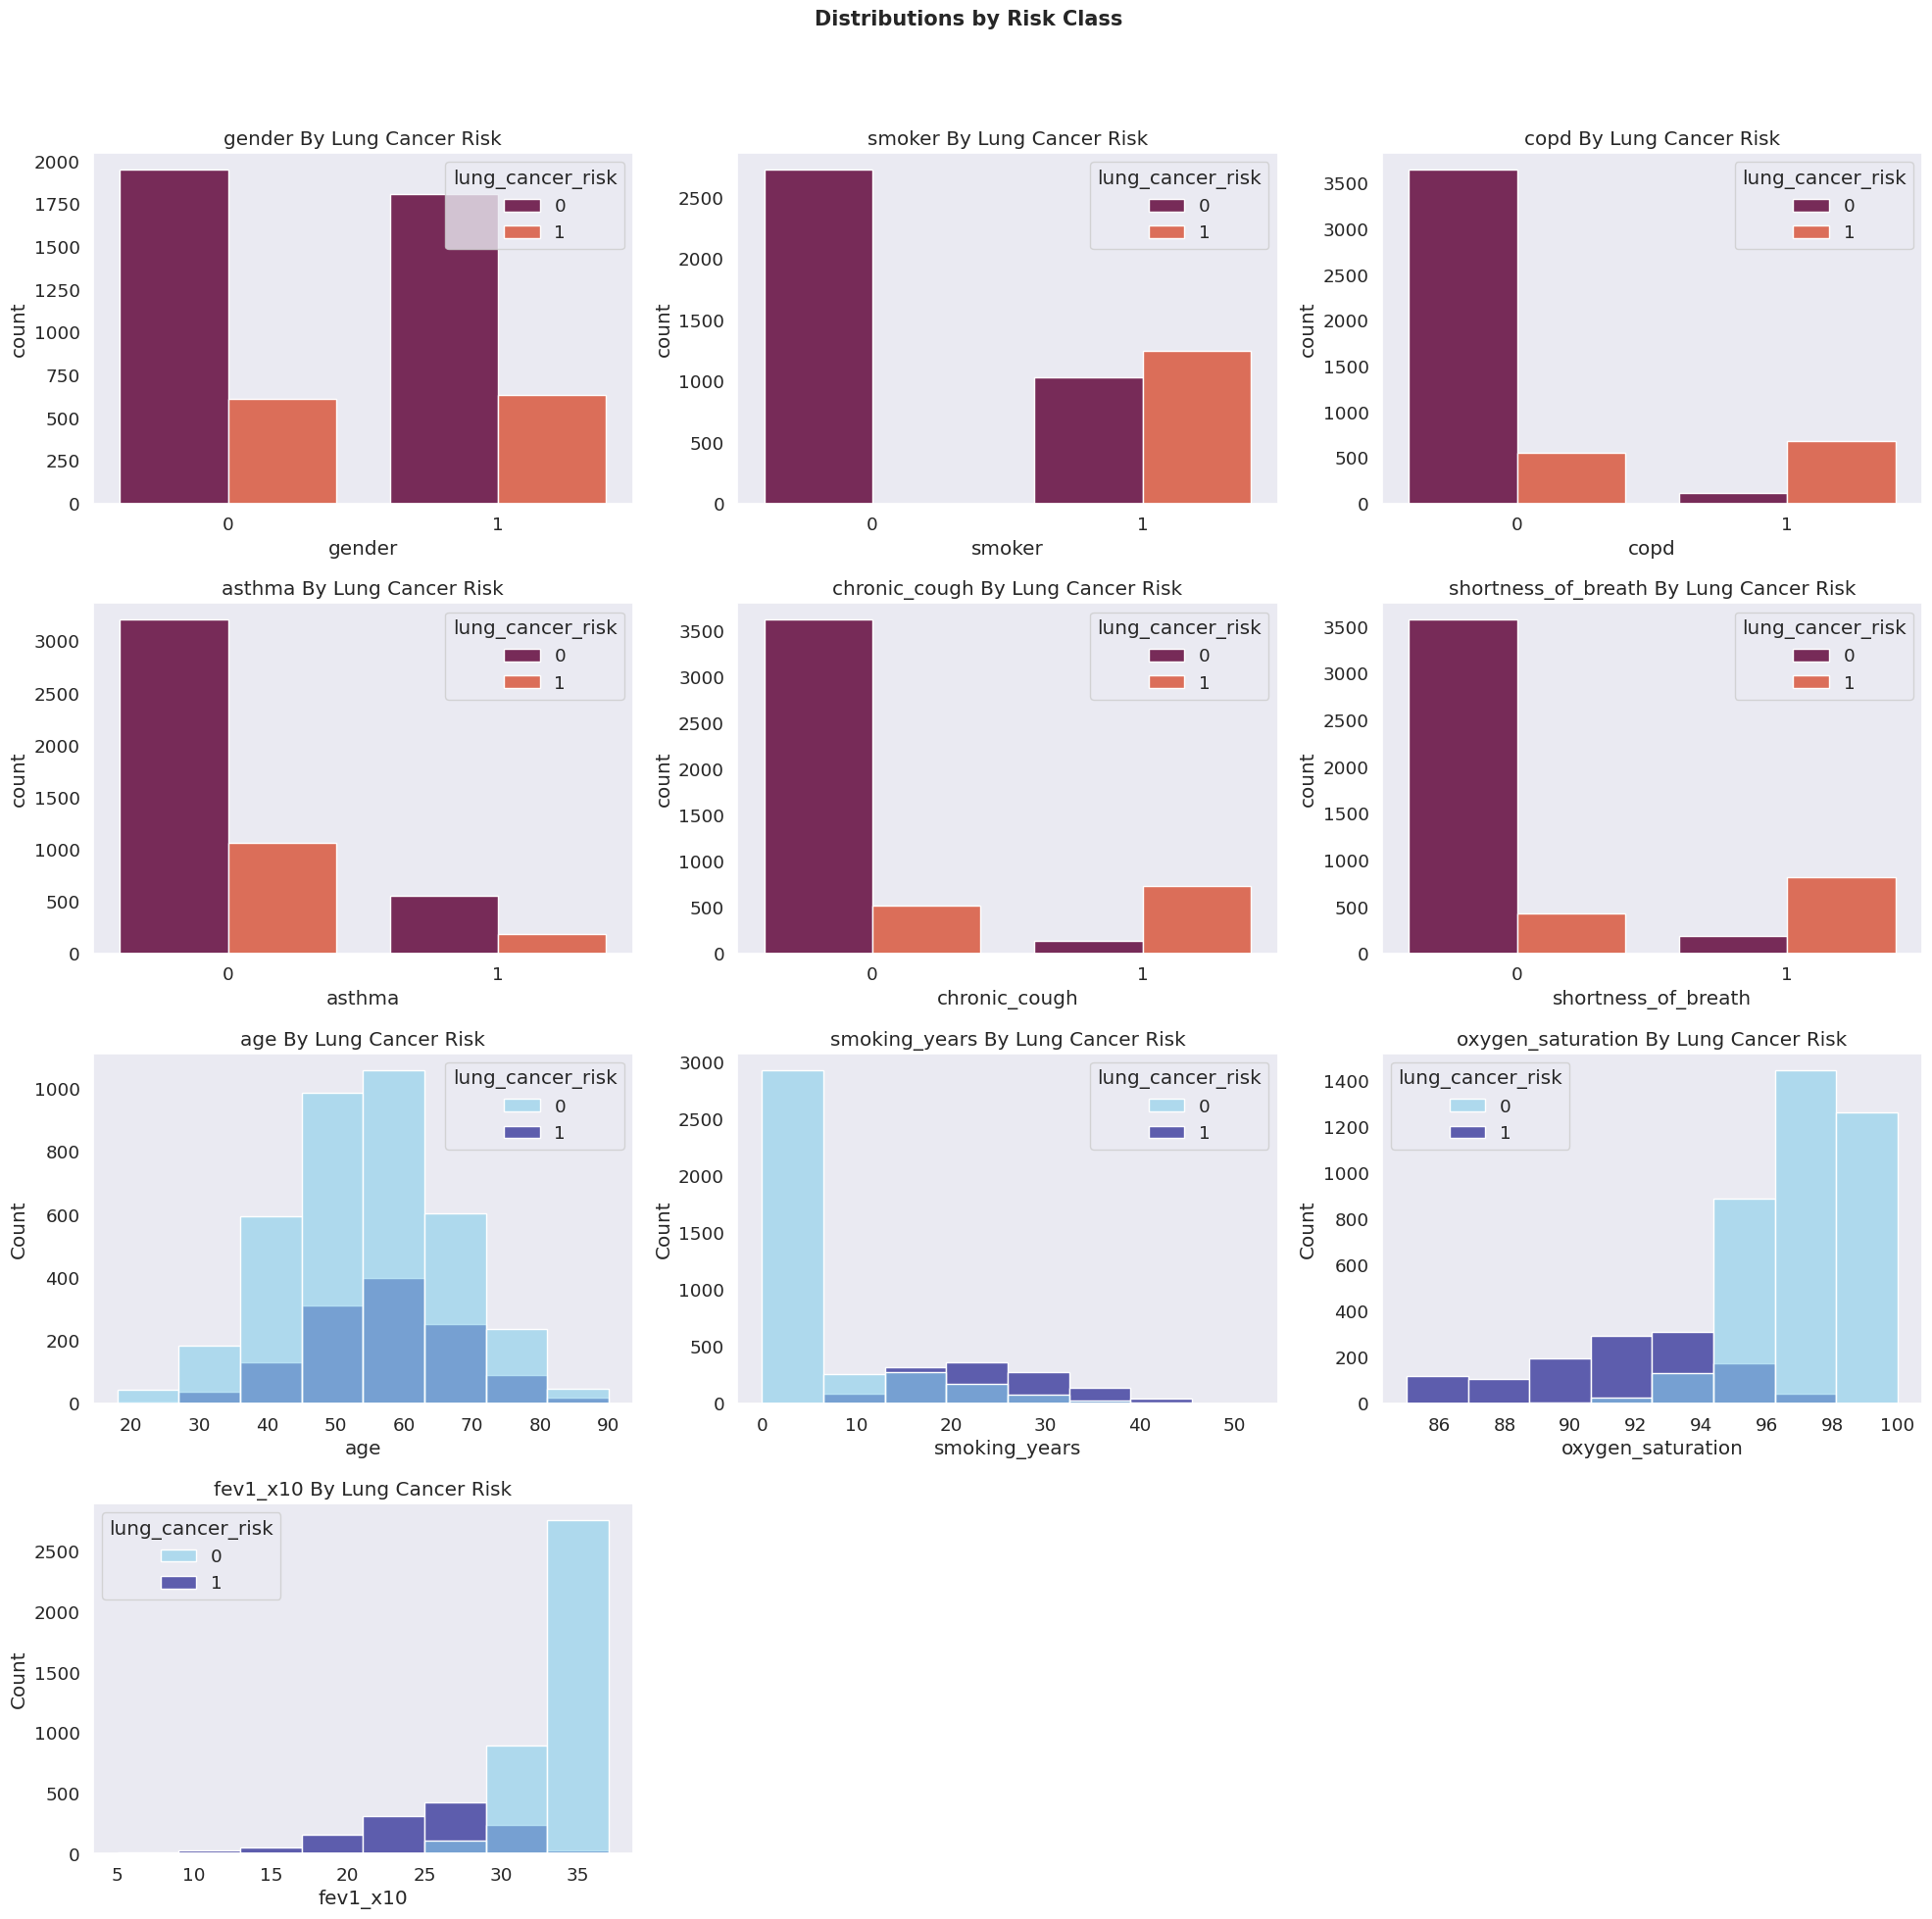

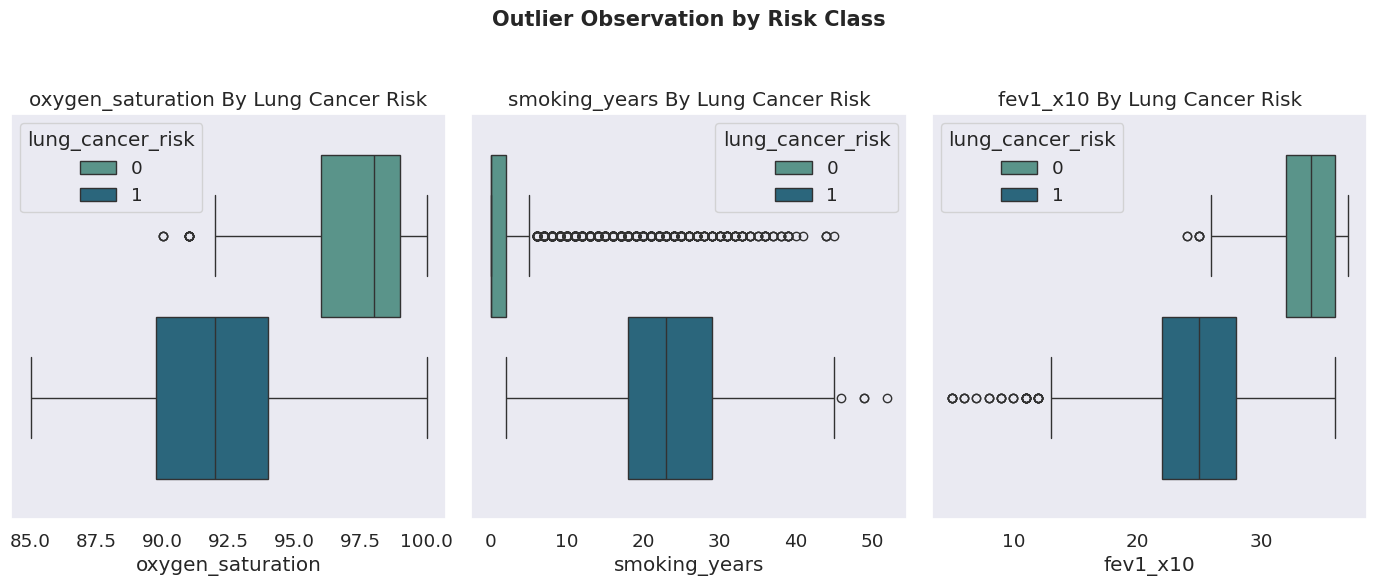

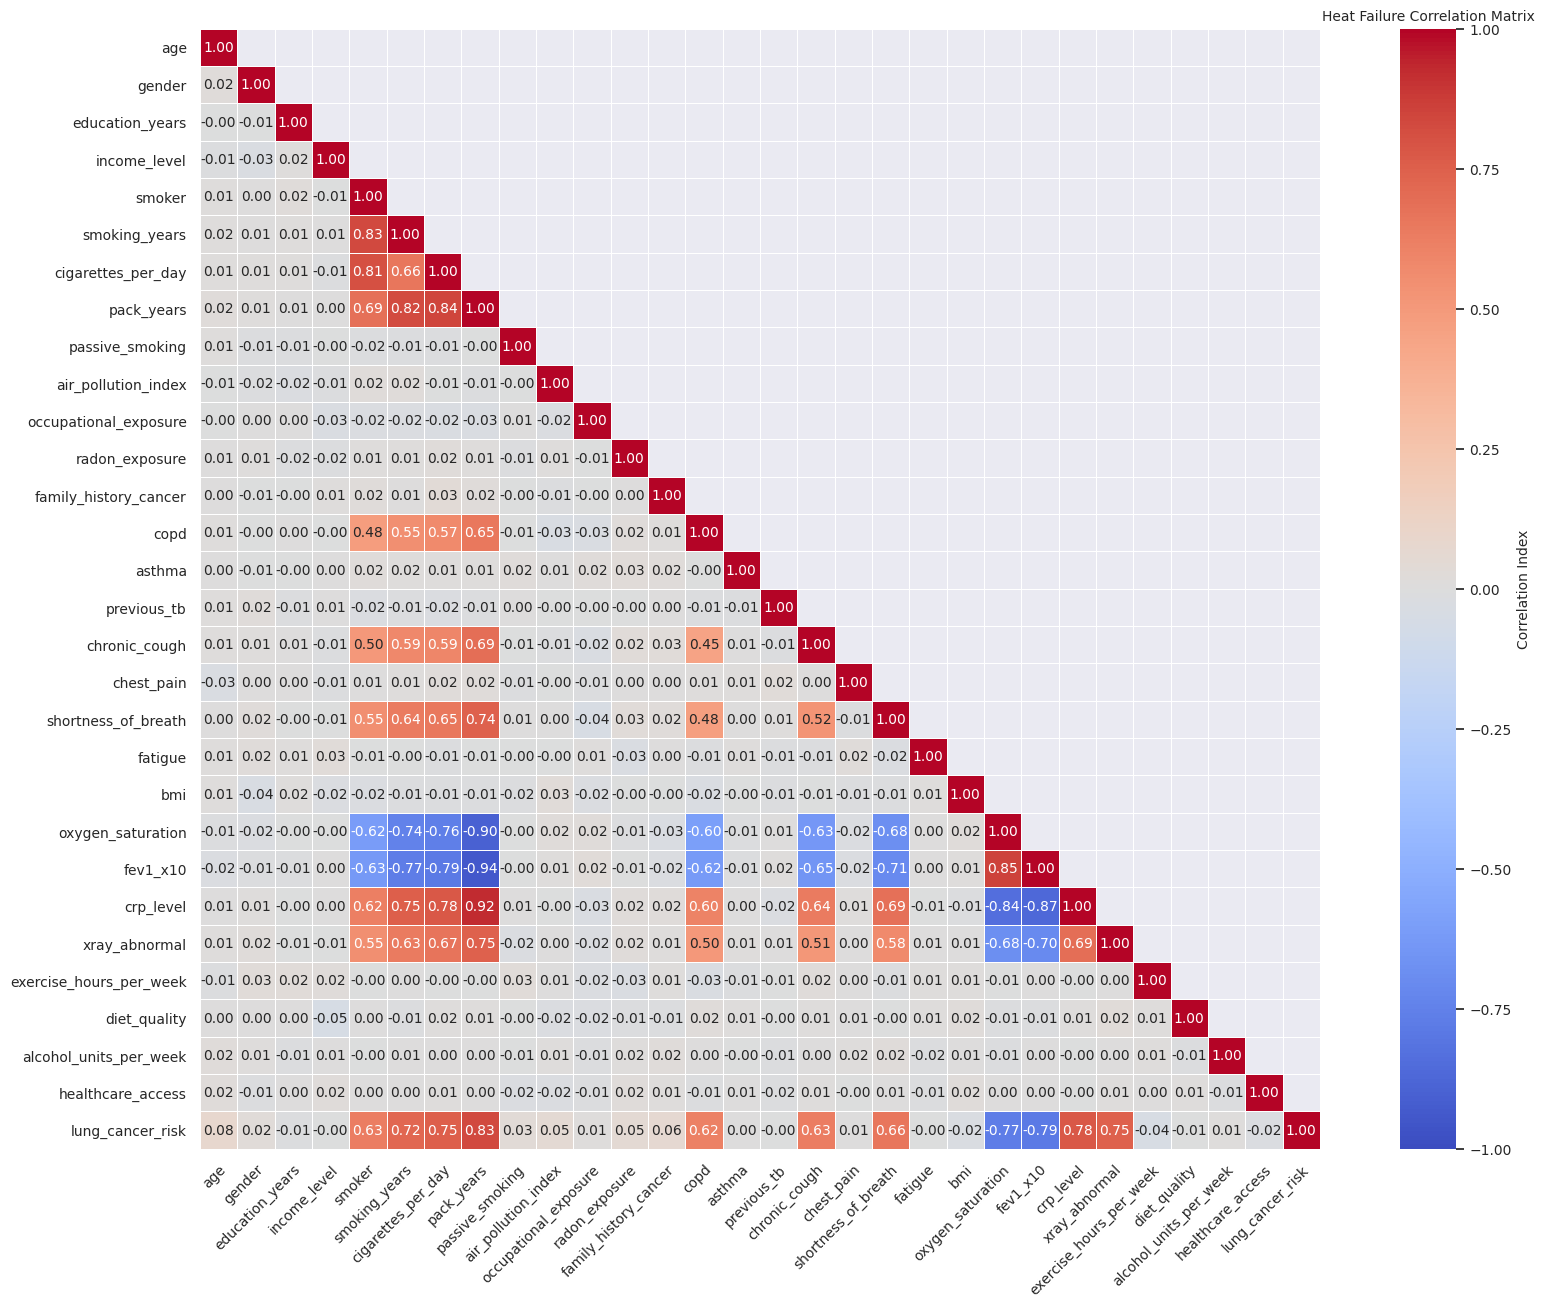

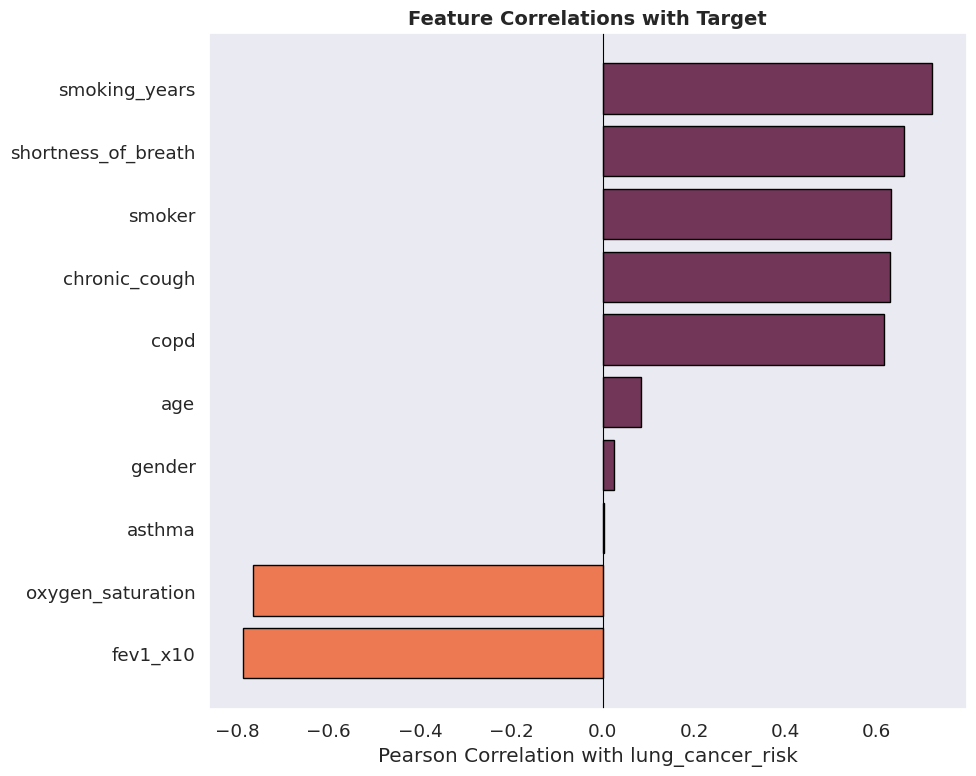





Total Execution time: 0:00:09.871375



In [85]:
warnings.simplefilter(action='ignore', category=FutureWarning)
timestamp_alltimes_start = datetime.now()
path = kagglehub.dataset_download("dhrubangtalukdar/lung-cancer-prediction-dataset")
df = pd.read_csv(path + '/lung_cancer.csv', sep=',', na_values=" ?", skipinitialspace=True)
TARGET = "lung_cancer_risk"

# =========== EDA =============
print("======== Preview of Data ======== ")
print(f"Sample of the data:\n{df.head()}")
print(f"\n(Rows, Columns) = {df.shape}\n")
df.info()
print(f"\nDescribe (numeric data): {df.describe()}")
print(f"\nNumber of duplicated rows: {df.duplicated().sum()}")
print(f"\nNumber of Null Values: {df.isnull().sum().sum()}")
print(f"\nProportion of high-risk patients: {(df[TARGET].sum() / len(df[TARGET])) * 100}%")

# Categorizing columns by type using Claude
BINARY_COLS = [
    "gender", "smoker", "passive_smoking", "occupational_exposure",
    "radon_exposure", "family_history_cancer", "copd", "asthma",
    "previous_tb", "chronic_cough", "chest_pain", "shortness_of_breath",
    "fatigue", "xray_abnormal"
]

ORDINAL_COLS = ["income_level", "diet_quality", "healthcare_access"]

CONTINUOUS_COLS = [
    "age", "education_years", "smoking_years", "cigarettes_per_day",
    "pack_years", "air_pollution_index", "bmi", "oxygen_saturation",
    "fev1_x10", "crp_level", "exercise_hours_per_week",
    "alcohol_units_per_week"
]

# =========== Additional Descriptive Stats =============

print("\n======== Descriptive Stats by Risk Class ========")
grouped = df.groupby(TARGET)[CONTINUOUS_COLS].agg(["mean", "std", "median"])
grouped_stacked = grouped.stack(level=0)
grouped_stacked.index.names = ["risk_class", "feature"]
print(grouped_stacked.round(2).to_string())

print("\n======== Skewness & Kurtosis (Continuous Features) ========")
skew_kurt = pd.DataFrame({
    "Skewness": df[CONTINUOUS_COLS].skew(),
    "Kurtosis": df[CONTINUOUS_COLS].kurtosis()
}).round(3)
print(skew_kurt.to_string())

# Color constants
purple = "#723658"
orange = "#ed7952"
EDGE = "black"

# =========== Plots =============

# ---- Target Distribution ----

fig, ax = plt.subplots(figsize=(6,6))
sns.countplot(data=df, x='lung_cancer_risk', palette="rocket", ax=ax)
total = len(df)
for p in ax.patches:
    count = int(p.get_height())
    percent = 100 * count / total

    ax.text(
        p.get_x() + p.get_width()/2,   # x position
        count + total*0.01,            # y position slightly above bar
        f"{count}\n({percent:.1f}%)",
        ha="center"
    )

ax.set_ylim(0, ax.get_ylim()[1] * 1.15)
ax.set_xticks([0, 1])
ax.set_xticklabels(["Low Risk (0)", "High Risk (1)"])
ax.set_xlabel(" Lung Cancer Risk")
ax.set_title("Target Variable Distribution")
plt.tight_layout()
plt.show()
print("\n\n\n")

# ---- Proportion Mean Plots ----

# Continuous features use the mean to show the average value per risk group.
# Binary (0/1) features use the mean to show the proportion of 1s in each group.

#imports
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

#use dark grid to match seaborn figures
sns.set_style("dark")
custom_palette = {0: "skyblue", 1: "navy"}

#adding  grid to make it look like one figure

#Sorting by demo, cont and bin (makes it look like 3 figure butits one )
DEMO = ["age"]
CONT = ["smoking_years", "oxygen_saturation", "fev1_x10"]
BIN  = ["gender", "asthma", "copd", "chronic_cough", "shortness_of_breath", "smoker"]

# keep only columns that exist
DEMO = [c for c in DEMO if c in df.columns]
CONT = [c for c in CONT if c in df.columns]
BIN  = [c for c in BIN  if c in df.columns]

def panel(ax, cols, title, palette, ylim=None, ylabel="Mean", alpha=0.7):
    # seaborn computes the mean per TARGET internally
    sub = df.melt(id_vars=TARGET, value_vars=cols, var_name="feature", value_name="value")
    sns.barplot(data=sub, x="feature", y="value", hue=TARGET,
                palette=palette, errorbar=None, ax=ax, alpha=alpha, width=0.5)
    ax.set_title(title, fontweight="bold")
    ax.set_xlabel("")
    ax.set_ylabel(ylabel)
    ax.tick_params(axis="x", rotation=45)
    if ylim:
        ax.set_ylim(*ylim)
    ax.legend(title="Lung Cancer Risk", labels=["Low (0)", "High (1)"])

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

panel(axes[0], DEMO, "Demographics", custom_palette, ylabel="Mean")
panel(axes[1], CONT, "Continuous Features", custom_palette, ylabel="Mean")
panel(axes[2], BIN,  "Binary Features", "rocket", ylim=(0, 1),
      ylabel="Proportion")

plt.suptitle("Selected Features by Risk Class", fontsize=15, fontweight="bold")
plt.tight_layout()
# Add border around entire figure
fig.patch.set_edgecolor("black")
fig.patch.set_linewidth(2)
plt.show()
print("\n\n\n")

# ---- Continuous Distributions By Class ----

def features_by_target(df, column_plot, num_cols, w, h, title):
  sns.set(font_scale=1.2, style="dark")
  custom_palette = {0: 'skyblue', 1: 'navy'}

  keys_list = list(column_plot.keys())
  values_list = list(column_plot.values())

  n_plots = len(column_plot)
  n_cols = num_cols
  n_rows = int(math.ceil(n_plots/n_cols))

  gs = gridspec.GridSpec(n_rows, n_cols)
  fig = plt.figure(figsize=(w,h))

  for i in range(n_plots):
   ax = fig.add_subplot(gs[i])
   if values_list[i] == 'hist':
     sns.histplot(data=df, x=keys_list[i], hue='lung_cancer_risk', palette=custom_palette, bins=8, alpha=0.6, ax=ax)
   elif values_list[i] == 'count':
     sns.countplot(data=df, x=keys_list[i], hue='lung_cancer_risk', palette="rocket", ax=ax)
   elif values_list[i] == 'box':
     sns.boxplot(data=df, x=keys_list[i], hue='lung_cancer_risk', palette="crest", ax=ax);
   else:
     print('Incorrect plot type, please check if column_plot has hist, count or box plots only.')
   ax.set_xlabel(keys_list[i])
   ax.set_title(f"{keys_list[i]} By Lung Cancer Risk")
  fig.suptitle(title, fontsize=15, fontweight="bold", y=0.98)
  plt.tight_layout(rect=[0, 0, 1, 0.95])

column_plot = {'gender':'count','smoker':'count','copd': 'count', 'asthma':'count', 'chronic_cough':'count', 'shortness_of_breath':'count','age':'hist', 'smoking_years':'hist', 'oxygen_saturation': 'hist', 'fev1_x10': 'hist'}
features_by_target(df, column_plot, 3, 20, 20, 'Distributions by Risk Class')
plt.show()
print("\n\n\n")
column_plot = {'oxygen_saturation':'box', 'smoking_years':'box', 'fev1_x10':'box'}
features_by_target(df, column_plot, 3, 14, 6, 'Outlier Observation by Risk Class')
plt.show()
print("\n\n\n")

# ---- Correlation Heatmap ----

#(Shpaner & Gil, 2024)
df_num = df.select_dtypes(np.number)
flex_corr_matrix(
    df=df,
    cols=df_num.columns.to_list(),
    annot=True,
    cmap="coolwarm",
    figsize=(18, 14),
    title="Heat Failure Correlation Matrix",
    xlabel_alignment="right",
    label_fontsize=10,
    tick_fontsize=10,
    xlabel_rot=45,
    ylabel_rot=0,
    text_wrap=50,
    vmin=-1,
    vmax=1,
    cbar_label="Correlation Index",
    triangular=True,
)
print("\n\n\n")

# ---- Feature Correlations with Target ----
narrowed_df = df[["age", "gender", "smoker", "smoking_years", "copd", "asthma", "chronic_cough", "shortness_of_breath", "oxygen_saturation", "fev1_x10", "lung_cancer_risk"]]
corr = narrowed_df.corr()
fig, ax = plt.subplots(figsize=(10, 8))
target_corr = corr[TARGET].drop(TARGET).sort_values()
colors = [purple if v > 0 else orange for v in target_corr.values]
ax.barh(target_corr.index, target_corr.values, color=colors, edgecolor=EDGE)
ax.set_xlabel("Pearson Correlation with lung_cancer_risk")
ax.set_title("Feature Correlations with Target",
             fontsize=14, fontweight="bold")
ax.axvline(0, color="black", linewidth=0.8)
plt.tight_layout()
plt.show()
print("\n\n\n")

timestamp_alltimes_end = datetime.now()
print(f"\033[1;32mTotal Execution time: {timestamp_alltimes_end - timestamp_alltimes_start}\n")



References:

Shpaner, L., & Gil, O. (2024). EDA Toolkit (Version 0.2.2) [Computer software]. Zenodo. https://doi.org/10.5281/zenodo.13162633

Waskom, M. L. (2021). seaborn: Statistical data visualization. Journal of Open Source Software, 6(60), 3021. https://doi.org/10.21105/joss.03021